This notebook illustrates geographic distribution of deployment of different electronic health record (EHR) software across England by CCG.

This is generated from a file available on request from NHS Digital.

In [1]:
##import libraries neededd
from ebmdatalab import bq
from ebmdatalab import maps
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sql = """
WITH
  practice_count AS (
  SELECT
    ccg_id,
    COUNT(*) AS total_practices
  FROM
    hscic.practices
  WHERE
    setting = 4 ##this is the code for a "normal" general practice in NHS BSA terms
    AND status_code = 'A'
  GROUP BY
    ccg_id)
SELECT
  TRIM(Principal_Supplier) AS supplier,
  practices.ccg_id AS pct,
  COUNT(*) AS count,
  total_practices
FROM
  hscic.vendors software ##this is the BQ place where we have saved NHS Digital monthly extracts
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  practice_count
ON
  practice_count.ccg_id = practices.ccg_id
WHERE
  practices.setting = 4
  AND practices.status_code = 'A'
  AND Date = '2018-12-01' ###latest data is December
GROUP BY
  supplier,
  practices.ccg_id, total_practices
  
  """

ehr_by_ccg = bq.cached_read(sql, csv_path="ehr_by_ccg.csv")
ehr_by_ccg = ehr_by_ccg.replace(['TPP'],'SystmOne')

In [3]:
##create an extra column with % deplyment across a CCG
ehr_by_ccg['percent'] = (ehr_by_ccg['count'] / ehr_by_ccg['total_practices'] * 100).round()
ehr_by_ccg = ehr_by_ccg.loc[ehr_by_ccg['pct']!='112'] ###ccg 112 is no longer a CCG so not supported by maps preApril2019
ehr_by_ccg.head(2)

,supplier,pct,count,total_practices,percent
0,SystmOne,00M,30,37,81.0
1,SystmOne,00L,32,41,78.0


C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


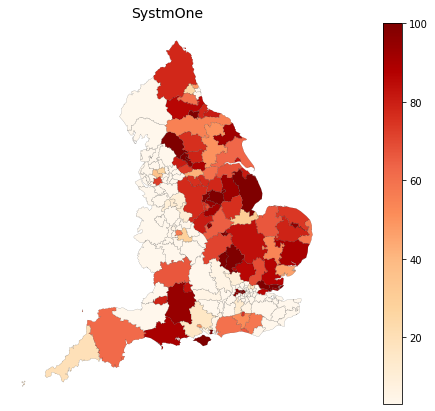

C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


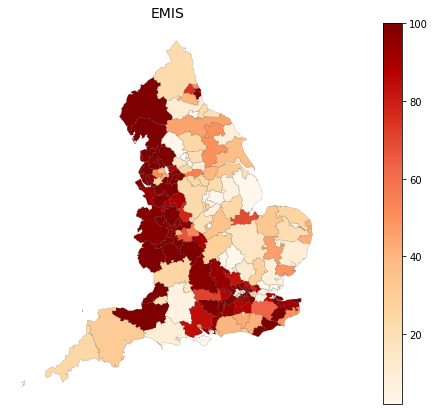

C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


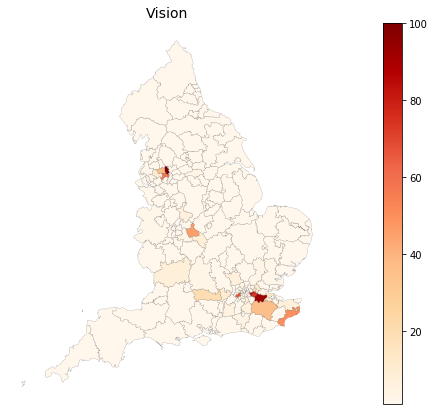

C:\Users\bmackenna\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


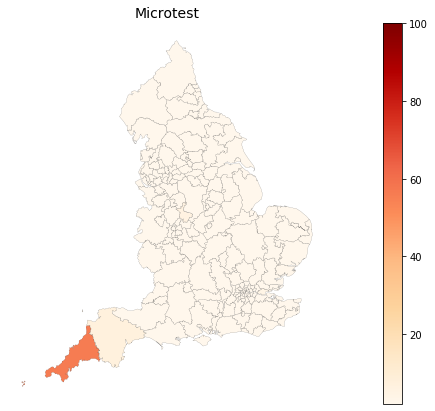

In [4]:
for supplier in ehr_by_ccg.supplier.unique():
    plt.figure(figsize=(20, 7))
    maps.ccg_map(
        ehr_by_ccg[ehr_by_ccg['supplier'] == supplier], 
        title=supplier,
        column='percent', 
        separate_london=False,
        plot_options={'vmax': 100}
    )
    plt.show()